In [1]:
# Importing the necessary libraries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed

# Setting ongoing plot size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 7

# Necessary for plots later
pd.plotting.register_matplotlib_converters()

2023-04-30 15:47:22.536860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 15:47:25.045159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkg/software_depot/app/gcc/rhel_7/11.2.0/lib64
2023-04-30 15:47:25.045202: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-30 15:47:43.356885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-darkgrid')

In [3]:
# Getting a look at the raw data
df = pd.read_csv('Data/zillow_data.csv')

# Dropping the SizeRank column, as well as the RegionID
df.drop(columns=['RegionID', 'SizeRank'], inplace=True)

# Rename RegionName to zipcode
df.rename(columns = {'RegionName' : 'zipcode'}, inplace = True)

# Melting dataframe to convert into Long Format
df2 = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName'], var_name='date')

#Converting 'date' column to datetime format
df2.date = pd.to_datetime(df2.date, format='%Y-%m')

# Grouping the data by zipcode
groups = df2.groupby('zipcode')

In [6]:
df2.date.min(), df2.date.max()

(Timestamp('1996-04-01 00:00:00'), Timestamp('2018-04-01 00:00:00'))

In [4]:
profitable_rent = pd.read_csv('Data/profitable_rent.csv', index_col = 0)

In [5]:
profitable_rent.head()

,sigma2,predicted_mean,lower_conf_mean,Region Name,City,State,P2R,National Average
zipcode,,,,,,,,
28205,0.000005,0.013835,-0.001576,"Charlotte, NC",Charlotte,NC,11.30,11.44
28227,0.000003,0.014862,-0.001880,"Charlotte, NC",Mint Hill,NC,11.30,11.44
78254,0.000002,0.002308,-0.004194,"San Antonio, TX",San Antonio,TX,9.87,11.44
30080,0.000004,0.012332,-0.004591,"Atlanta, GA",Smyrna,GA,10.93,11.44
78130,0.000004,0.005089,-0.004786,"San Antonio, TX",New Braunfels,TX,9.87,11.44


In [6]:
## aggregating profitable zipcodes by States
profitable_rent.groupby('State').mean().sort_values('P2R').head(10)
## states with highest average lease profitability are AR, IN, MI, TX, OH

,sigma2,predicted_mean,lower_conf_mean,P2R,National Average
State,,,,,
AR,0.000008,0.008095,-0.014502,9.390000,11.44
IN,0.000003,0.003195,-0.011580,9.610000,11.44
MI,0.000005,0.005299,-0.013660,9.630000,11.44
TX,0.000004,0.005695,-0.009865,9.813333,11.44
OH,0.000004,0.004991,-0.011117,9.870000,11.44
SC,0.000005,0.006336,-0.013803,9.950000,11.44
AL,0.000004,0.004203,-0.011632,9.970000,11.44
NY,0.000003,0.003025,-0.012740,10.060000,11.44
OK,0.000002,0.001308,-0.008713,10.130000,11.44


In [5]:
## subsetting states with highest average lease profitability
high_p2r_state = profitable_rent[profitable_rent['State'].isin(['AR', 'TX', 'SC', 'AL', 'NY'])]

In [8]:
## aggregating zipcodes by region name from subset of states having high avg lease profitability
high_p2r_state.groupby('Region Name').mean().sort_values(['lower_conf_mean'], ascending = False).head(20)

,sigma2,predicted_mean,lower_conf_mean,P2R,National Average
Region Name,,,,,
"College Station, TX",0.000004,0.008228,-0.007047,9.51,11.44
"San Antonio, TX",0.000003,0.004018,-0.008118,9.87,11.44
"Birmingham, AL",0.000004,0.006074,-0.008973,10.11,11.44
"Dallas-Fort Worth, TX",0.000004,0.007215,-0.009458,10.69,11.44
"Houston, TX",0.000003,0.005348,-0.010478,9.28,11.44
"Buffalo, NY",0.000004,0.002431,-0.012547,9.77,11.44
"Albany, NY",0.000003,0.004211,-0.013125,10.64,11.44
"Columbia, SC",0.000003,0.003831,-0.013628,9.39,11.44
"Myrtle Beach, SC",0.000009,0.011347,-0.014153,11.07,11.44


In [6]:
## lets have a diverse portfolio so that it is not very over exposed thus only selecting one region from each state
## also lets select regions with avg P2R less than 10 for it to be in utility class
high_p2r_region = high_p2r_state[high_p2r_state['Region Name'].isin(['San Antonio, TX', 'El Paso, TX',
                                                                     'Houston, TX', 'Buffalo, NY',
                                                                     'Columbia, SC', 'Montgomery, AL',
                                                                     'Jonesboro, AR'])]

In [7]:
## aggregating zipcodes by cities from subset of regions having low avg lower conf mean from states
## having high avg lease profitability
high_p2r_city = high_p2r_region.groupby('City').mean().sort_values('lower_conf_mean', ascending = False).index

In [11]:
high_p2r_city

Index(['New Braunfels', 'Mission Bend', 'Tomball', 'San Antonio',
       'League City', 'Atascocita', 'Pearland', 'Amherst', 'Baytown',
       'Cypress', 'Houston', 'Cinco Ranch', 'Columbia', 'Lexington',
       'Montgomery', 'El Paso', 'Jonesboro', 'Lockport'],
      dtype='object', name='City')

In [11]:
high_p2r_region[high_p2r_region['City'].isin(high_p2r_city)].reset_index().groupby('City', as_index = False).first().set_index('zipcode').sort_values('predicted_mean', ascending = False)

,City,sigma2,predicted_mean,lower_conf_mean,Region Name,State,P2R,National Average
zipcode,,,,,,,,
77083,Mission Bend,0.000003,0.010138,-0.007062,"Houston, TX",TX,9.28,11.44
72401,Jonesboro,0.000008,0.008095,-0.014502,"Jonesboro, AR",AR,9.39,11.44
77584,Pearland,0.000002,0.005170,-0.009794,"Houston, TX",TX,9.28,11.44
78130,New Braunfels,0.000004,0.005089,-0.004786,"San Antonio, TX",TX,9.87,11.44
77346,Atascocita,0.000002,0.004897,-0.009569,"Houston, TX",TX,9.28,11.44
77573,League City,0.000003,0.004834,-0.009263,"Houston, TX",TX,9.28,11.44
77521,Baytown,0.000003,0.004582,-0.010474,"Houston, TX",TX,9.28,11.44
77429,Cypress,0.000003,0.004085,-0.011234,"Houston, TX",TX,9.28,11.44
77070,Houston,0.000002,0.003849,-0.008206,"Houston, TX",TX,9.28,11.44


In [14]:
profitable_zips

Int64Index([77083, 72401, 77584, 78130, 77346, 77573, 77521, 77429, 77070,
            29072, 29223, 77450, 77379, 14094, 36117, 78254, 14221, 79924],
           dtype='int64', name='zipcode')

In [13]:
profitable_zips = high_p2r_region[high_p2r_region['City'].isin(high_p2r_city)].reset_index().groupby('City', as_index = False).first().set_index('zipcode').sort_values('predicted_mean', ascending = False).index

In [37]:
for zip_code in tqdm.tqdm(profitable_zips):
    
    print(f"[running for zip:{zip_code}...]")
    
    print("[extracting zip data...]")
    ## exxtract city data from zip
    city = groups.get_group(zip_code).City.unique()[0]
    view_zip = groups.get_group(zip_code).set_index('date').value
    view_zip_returns = np.log(view_zip).diff().dropna().asfreq('MS')
    view_zip_returns.name = f'{city}_log_returns'
    
    print("[getting best model parameters...]")
    ## get best model parameters
    auto_arima_model = pm.auto_arima(view_zip_returns, information_criterion = 'bic')
    seasonal, non_seasonal = auto_arima_model.get_params()['seasonal_order'], auto_arima_model.get_params()['order']
    
    print("[fitting model...]")
    ## fit model with best parameters
    model = SARIMAX(view_zip_returns,
                order = non_seasonal,
                seasonal_order = seasonal,
                enforce_invertibility = False,
                enforce_stationarity = False).fit(disp = False)

    
    print("[getting in_sample forecasts...]")
    ##in-sample_forecast
    # Get predictions
    pred = model.get_prediction(dynamic='2008-04-01')
    pred_conf = pred.conf_int().loc['2008-04':]
    # Plot observed values
    ax = view_zip_returns.plot(label='observed');
    # Plot predicted values
    pred.predicted_mean.loc['2008-04':].plot(ax=ax, label='One-step ahead Forecast', color='orange', alpha=0.9);
    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index, 
                    pred_conf.iloc[:, 0], 
                    pred_conf.iloc[:, 1],
                    alpha=0.3
                   );
    # Set axes labels
    ax.set_xlabel('Date');
    ax.set_ylabel('Log Returns');
    plt.legend();
    plt.savefig(f'Data/Plots/{city}_in_sample_forecast.png', dpi = 200, bbox_inches = 'tight');
    plt.close()
    
    
    print("[getting out_sample forecasts...]")
    ## out-sample_forecast
    periods_ahead = 120
    constant = pd.Series(np.ones(periods_ahead))

    # Get forecast
    prediction = model.get_forecast(periods_ahead, exog=constant)

    # Get confidence intervals of forecast
    pred_conf = prediction.conf_int()

    # Plot future predictions with confidence intervals
    ax = view_zip_returns.plot(label='observed');
    prediction.predicted_mean.plot(label='Forecasted values', ax=ax);

    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1],
                    alpha=0.3
                   )

    ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                     alpha=0.1,
                     zorder=-1
                    )

    ax.set_title(f'{city} Log Returns 10 year forecast');
    ax.set_xlabel('Date');
    ax.set_ylabel('Log Returns');
    plt.legend();
    plt.savefig(f'Data/Plots/{city}_out_sample_forecast.png', dpi = 200, bbox_inches = 'tight');
    plt.close()

  0%|                                                    | 0/18 [00:00<?, ?it/s]

[running for zip:14221...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


  6%|██▍                                         | 1/18 [00:03<00:56,  3.34s/it]

[running for zip:77346...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 11%|████▉                                       | 2/18 [00:07<01:04,  4.01s/it]

[running for zip:77521...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 17%|███████▎                                    | 3/18 [00:13<01:13,  4.91s/it]

[running for zip:77450...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 22%|█████████▊                                  | 4/18 [00:17<01:04,  4.59s/it]

[running for zip:29223...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 28%|████████████▏                               | 5/18 [00:21<00:53,  4.09s/it]

[running for zip:77429...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 33%|██████████████▋                             | 6/18 [00:27<00:57,  4.82s/it]

[running for zip:79924...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 39%|█████████████████                           | 7/18 [00:33<00:58,  5.36s/it]

[running for zip:77070...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 44%|███████████████████▌                        | 8/18 [00:38<00:50,  5.06s/it]

[running for zip:72401...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 50%|██████████████████████                      | 9/18 [00:42<00:42,  4.69s/it]

[running for zip:77573...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 56%|███████████████████████▉                   | 10/18 [00:47<00:39,  4.88s/it]

[running for zip:29072...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 61%|██████████████████████████▎                | 11/18 [00:51<00:33,  4.76s/it]

[running for zip:14094...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 67%|████████████████████████████▋              | 12/18 [00:55<00:26,  4.36s/it]

[running for zip:77083...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 72%|███████████████████████████████            | 13/18 [00:58<00:20,  4.13s/it]

[running for zip:36117...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 78%|█████████████████████████████████▍         | 14/18 [01:04<00:18,  4.69s/it]

[running for zip:78130...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 83%|███████████████████████████████████▊       | 15/18 [01:10<00:14,  4.99s/it]

[running for zip:77584...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 89%|██████████████████████████████████████▏    | 16/18 [01:15<00:09,  4.88s/it]

[running for zip:78254...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


 94%|████████████████████████████████████████▌  | 17/18 [01:18<00:04,  4.38s/it]

[running for zip:77379...]
[extracting zip data...]
[getting best model parameters...]
[fitting model...]
[getting in_sample forecasts...]
[getting out_sample forecasts...]


100%|███████████████████████████████████████████| 18/18 [01:21<00:00,  4.54s/it]


In [40]:
## profitable zip codes:14221, 77346, 29223, 14094, 36117, 78130
## profitablee zip codes come from states TX, SC, AL, NY

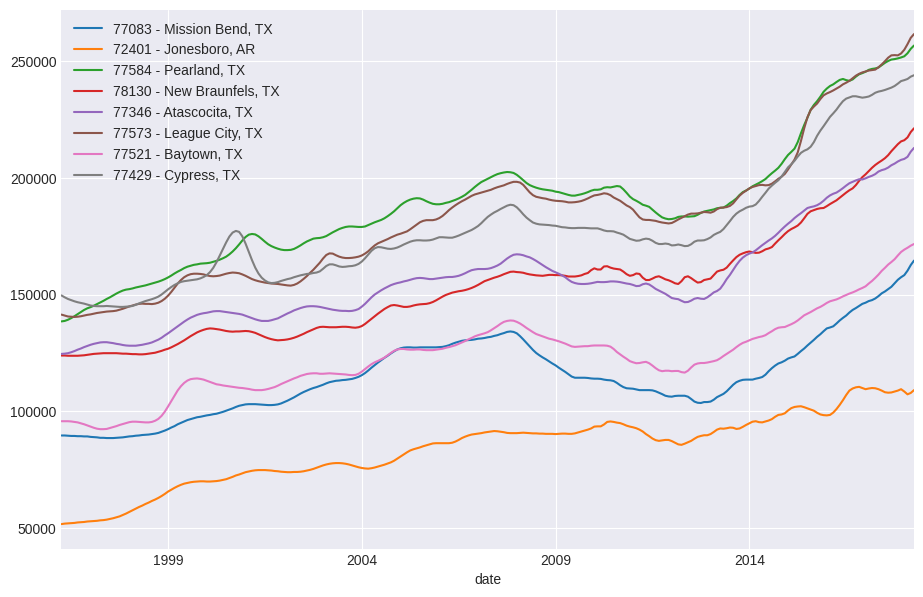

In [18]:
for i, zipcode in enumerate(profitable_zips[:8]):
    group = groups.get_group(zipcode).set_index('date')
    group.value.plot(label=str(zipcode)+' - '+group.City.iloc[0]+', '+group.State.iloc[0])
    
    if i == len(profitable_zips[:8])-1:
        plt.legend()
        plt.show()

## Single step LSTM Approach for the selected zipcodes

In [20]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.reset_index(drop = True)

In [21]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_lag, n_seq):
    # extract raw values
    #raw_values = series.values
    # log transform
    #log_values = np.log(raw_values)
    # transform data to be stationary
    diff_series = series.diff().dropna()
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values.reshape(-1,1))
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    return scaler, supervised_values

In [22]:
def split_data(data):
    X, y = data[:,0:data.shape[1]-1], data[:,data.shape[1]-1]
    X, y = X.reshape(X.shape[0], X.shape[1], 1), y.reshape(y.shape[0], 1)
    return X, y

In [23]:
def fit_model(X, y):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(250, return_sequences=True, batch_input_shape=(1,X.shape[1],1), stateful = True))
    model.add(LSTM(250, return_sequences=False, stateful = True))
    model.add(Dense(25))
    model.add(Dense(1))
    model.summary()
    
    model.compile(loss='mse', optimizer='adam', metrics = ['mse'])
    
    model.fit(X, y, epochs=100, batch_size = 1, validation_split = .35, verbose=1)
    return model

In [24]:
def get_forecasts(model, X, y, n_future = 120):
    model.reset_states()
    predictions = model.predict(X, batch_size = 1)
    
    x_pred = X[-1,:,:]
    y_pred = y[-1]
    y_future = []
    
    for i in tqdm.tqdm(range(n_future)):
    
        # feed the last forecast back to the model as an input
        x_pred = np.append(x_pred.flatten()[1:], y_pred.flatten()[0]).reshape(-1,X.shape[1],1)

        # generate the next forecast
        y_pred = model.predict(x_pred, batch_size = 1)

        # save the forecast
        y_future.append(y_pred.flatten()[0])
    
    return y_future

In [25]:
def plot_forecasts(scaler, in_sample, out_sample, title, filename, n_future = 120):
    
    ## Invert scaler transform
    out_sample = np.array(out_sample)
    y_future_inv_tnsf = scaler.inverse_transform(out_sample.reshape(-1,1))
    
    ## Invert diff transform
    y_future_orig = np.zeros(n_future)
    y_future_orig[0] = y_future_inv_tnsf[0] + in_sample.iloc[-1]
    for i in range(1, n_future):
        y_future_orig[i] = y_future_inv_tnsf[i-1]+y_future_orig[i-1]
    
    df_future = pd.Series(y_future_orig)
    df_future.index = pd.date_range(start = '2018-05-01', periods=n_future, freq = 'M')
    
    plt.plot(in_sample, label = 'In-Sample');
    plt.plot(df_future, label = 'Out_Sample forecast');
    plt.title(title);
    plt.grid()
    plt.legend();
    plt.savefig(f'Data/Plots/{filename}.png', bbox_inches = 'tight', dpi = 200);
    
    return 0

In [36]:
data_tb = groups.get_group(77379).set_index('date')['value']

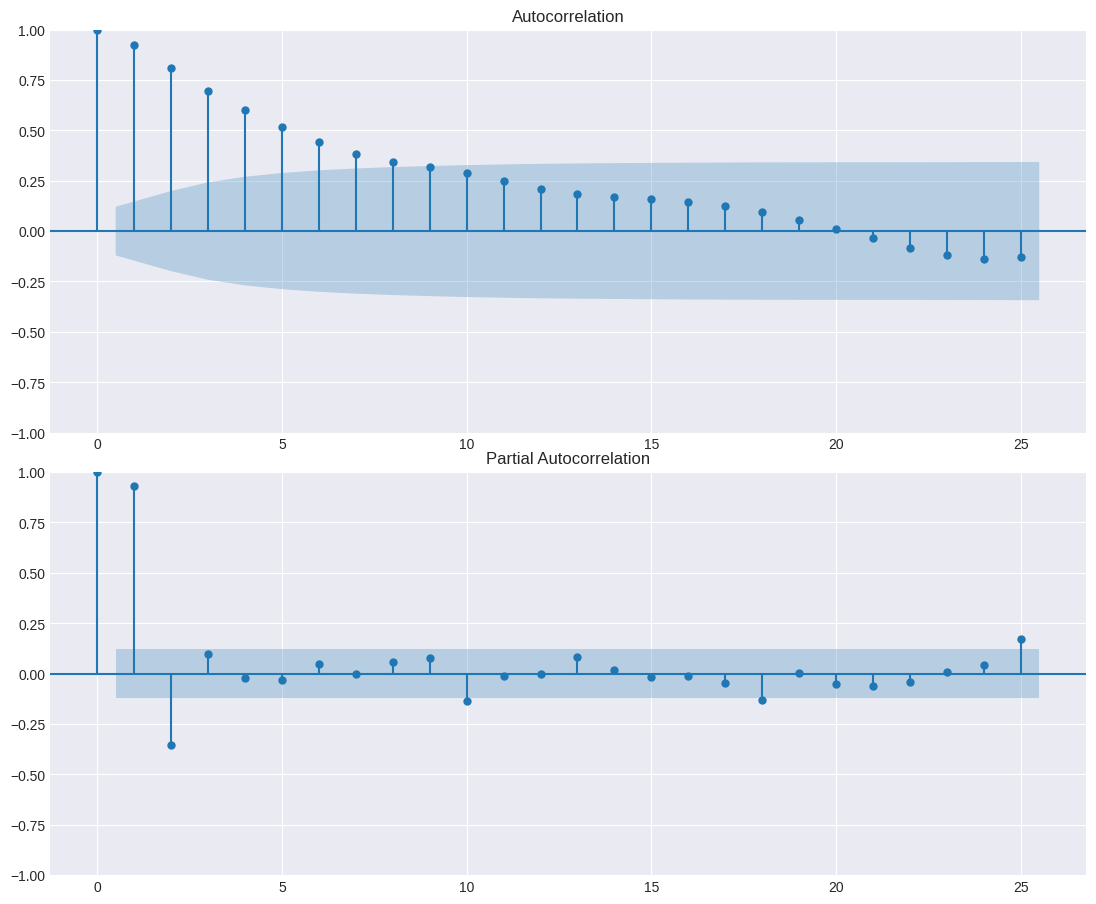

In [37]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(11,9))
plt.tight_layout()

plot_acf(np.log(data_tb).diff().dropna(), ax=ax1);
plot_pacf(np.log(data_tb).diff().dropna(), ax=ax2);
plt.show()

In [38]:
series_to_supervised(data_tb.to_list(), n_in = 2)

,var1(t-2),var1(t-1),var1(t)
0,168400.0,165900.0,163400.0
1,165900.0,163400.0,161000.0
2,163400.0,161000.0,158900.0
3,161000.0,158900.0,157200.0
4,158900.0,157200.0,155900.0
5,157200.0,155900.0,155000.0
6,155900.0,155000.0,154200.0
7,155000.0,154200.0,153700.0
8,154200.0,153700.0,153300.0
9,153700.0,153300.0,153300.0


In [39]:
scaler, train_data = prepare_data(data_tb, 2, 1)

In [40]:
X, y = split_data(train_data)

In [41]:
model = fit_model(X, y)
y_future = get_forecasts(model, X, y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 2, 250)               252000    
                                                                 
 lstm_3 (LSTM)               (1, 250)                  501000    
                                                                 
 dense_2 (Dense)             (1, 25)                   6275      
                                                                 
 dense_3 (Dense)             (1, 1)                    26        
                                                                 
Total params: 759,301
Trainable params: 759,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
170/170 [==============================] - 5s 11ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 2/100
170/170 [=========================

170/170 [==============================] - 1s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 56/100
170/170 [==============================] - 1s 7ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 57/100
170/170 [==============================] - 1s 7ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 58/100
170/170 [==============================] - 1s 7ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 59/100
170/170 [==============================] - 1s 7ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 60/100
170/170 [==============================] - 1s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 61/100
170/170 [==============================] - 1s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 62/100
170/170 [==============================] - 1s 7ms/step - loss:

  0%|                                                   | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▋                                          | 2/120 [00:00<00:09, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


  3%|█▍                                         | 4/120 [00:00<00:07, 14.60it/s]

1/1 [==============================] - 0s 19ms/step


  5%|██▏                                        | 6/120 [00:00<00:06, 16.42it/s]

1/1 [==============================] - 0s 21ms/step


  7%|██▊                                        | 8/120 [00:00<00:06, 17.05it/s]

1/1 [==============================] - 0s 23ms/step


  8%|███▌                                      | 10/120 [00:00<00:06, 17.75it/s]

1/1 [==============================] - 0s 19ms/step


 11%|████▌                                     | 13/120 [00:00<00:05, 18.99it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█████▌                                    | 16/120 [00:00<00:05, 19.58it/s]

1/1 [==============================] - 0s 20ms/step


 16%|██████▋                                   | 19/120 [00:01<00:05, 20.12it/s]

1/1 [==============================] - 0s 21ms/step


 18%|███████▋                                  | 22/120 [00:01<00:04, 20.28it/s]

1/1 [==============================] - 0s 19ms/step


 21%|████████▊                                 | 25/120 [00:01<00:04, 19.95it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▍                                | 27/120 [00:01<00:04, 18.60it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██████████▏                               | 29/120 [00:01<00:04, 18.37it/s]

1/1 [==============================] - 0s 19ms/step


 27%|███████████▏                              | 32/120 [00:01<00:04, 19.27it/s]

1/1 [==============================] - 0s 20ms/step


 29%|████████████▎                             | 35/120 [00:01<00:04, 19.81it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████▉                             | 37/120 [00:01<00:04, 19.85it/s]

1/1 [==============================] - 0s 20ms/step


 33%|██████████████                            | 40/120 [00:02<00:03, 20.23it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███████████████                           | 43/120 [00:02<00:03, 20.33it/s]

1/1 [==============================] - 0s 23ms/step


 38%|████████████████                          | 46/120 [00:02<00:03, 20.21it/s]

1/1 [==============================] - 0s 20ms/step


 41%|█████████████████▏                        | 49/120 [00:02<00:03, 20.45it/s]

1/1 [==============================] - 0s 18ms/step


 43%|██████████████████▏                       | 52/120 [00:02<00:03, 20.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|███████████████████▎                      | 55/120 [00:02<00:03, 18.74it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████████████████████▎                     | 58/120 [00:03<00:03, 19.38it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████████████████████                     | 60/120 [00:03<00:03, 19.39it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████████████████████▋                    | 62/120 [00:03<00:03, 18.23it/s]

1/1 [==============================] - 0s 19ms/step


 53%|██████████████████████▍                   | 64/120 [00:03<00:03, 18.22it/s]

1/1 [==============================] - 0s 20ms/step


 56%|███████████████████████▍                  | 67/120 [00:03<00:02, 19.00it/s]

1/1 [==============================] - 0s 20ms/step


 57%|████████████████████████▏                 | 69/120 [00:03<00:02, 19.11it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████████████████████████▏                | 72/120 [00:03<00:02, 19.70it/s]

1/1 [==============================] - 0s 22ms/step


 62%|█████████████████████████▉                | 74/120 [00:03<00:02, 19.50it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████████████████████████▌               | 76/120 [00:03<00:02, 19.61it/s]

1/1 [==============================] - 0s 20ms/step


 66%|███████████████████████████▋              | 79/120 [00:04<00:02, 20.09it/s]

1/1 [==============================] - 0s 19ms/step


 68%|████████████████████████████▋             | 82/120 [00:04<00:01, 20.50it/s]

1/1 [==============================] - 0s 19ms/step


 71%|█████████████████████████████▊            | 85/120 [00:04<00:01, 19.41it/s]

1/1 [==============================] - 0s 23ms/step


 72%|██████████████████████████████▍           | 87/120 [00:04<00:01, 19.17it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████████████████████████████▌          | 90/120 [00:04<00:01, 19.70it/s]

1/1 [==============================] - 0s 19ms/step


 78%|████████████████████████████████▌         | 93/120 [00:04<00:01, 20.09it/s]

1/1 [==============================] - 0s 20ms/step


 80%|█████████████████████████████████▌        | 96/120 [00:04<00:01, 20.21it/s]

1/1 [==============================] - 0s 19ms/step


 82%|██████████████████████████████████▋       | 99/120 [00:05<00:01, 20.48it/s]

1/1 [==============================] - 0s 23ms/step


 85%|██████████████████████████████████▊      | 102/120 [00:05<00:00, 19.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|███████████████████████████████████▌     | 104/120 [00:05<00:00, 19.73it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████▏    | 106/120 [00:05<00:00, 19.09it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████████████████████████████████▏   | 109/120 [00:05<00:00, 19.42it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████████████████████████████████▉   | 111/120 [00:05<00:00, 19.13it/s]

1/1 [==============================] - 0s 23ms/step


 94%|██████████████████████████████████████▌  | 113/120 [00:05<00:00, 19.06it/s]

1/1 [==============================] - 0s 20ms/step


 96%|███████████████████████████████████████▎ | 115/120 [00:05<00:00, 19.18it/s]

1/1 [==============================] - 0s 25ms/step


 98%|███████████████████████████████████████▉ | 117/120 [00:06<00:00, 18.59it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 19.32it/s]


0

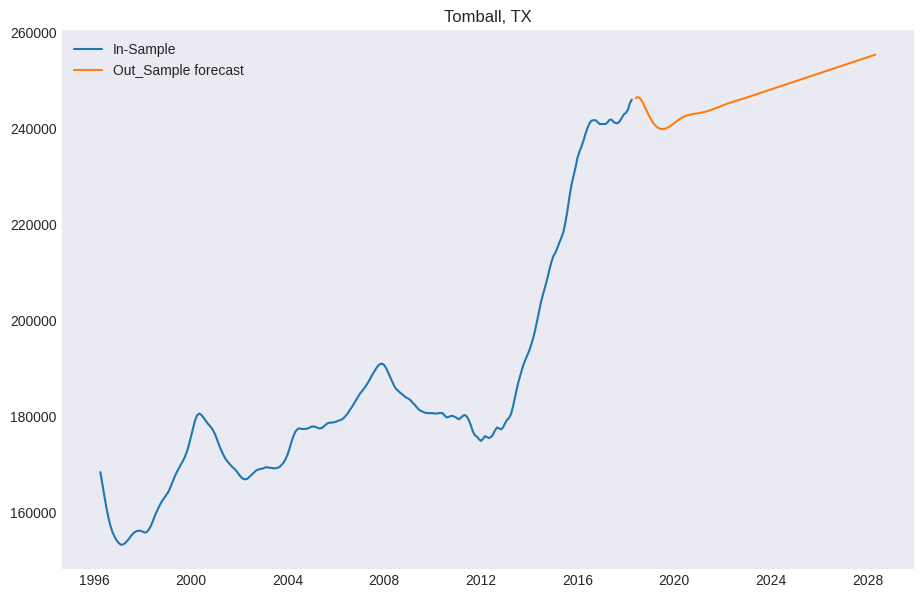

In [42]:
plot_forecasts(scaler, data_tb, y_future, 'Tomball, TX', 'Tomball_LSTM_forecast')